<a href="https://colab.research.google.com/github/susie682/Infosys722--Assignment-4-BDAS/blob/main/4_1_DataReduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Figures 42–46 (Strict 8‑Variable Version) — Chicago Crime 2017


This notebook **strictly reproduces** the Data Reduction figures using the original **8 candidate predictors**:

- District_Month_ArrestRate  
- District_Month_DomesticRate  
- NightShare_DistMonth  
- OutdoorShare_DistMonth  
- Lag1_Count_DistMonth  
- Lag3_Count_DistMonth  
- Roll3Mean_DistMonth  
- Z_Count_DistMonth  

All figures are rendered inline and saved under `/content/drive/MyDrive/Infosys 722/figs/`.


In [1]:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

FIG_DIR = "/content/drive/MyDrive/Infosys 722/figs"
TAB_DIR = "/content/drive/MyDrive/Infosys 722/tables"
RAW_CSV = "/content/drive/MyDrive/Infosys 722/CrimeData_2017.csv"
os.makedirs(FIG_DIR, exist_ok=True); os.makedirs(TAB_DIR, exist_ok=True)
print("Directories ready.")


Mounted at /content/drive
Directories ready.


In [6]:
# --- Build a clean plotting table with ONE canonical column per feature ---
import pandas as pd
import numpy as np
import os, glob

# dm 已经加载，这里从 dm 生成 df_plot
def pick(df, *names):
    """Return the first existing column from names; else None."""
    for n in names:
        if n in df.columns:
            return df[n]
    return None

cols_core = []
if "District" in dm.columns: cols_core.append("District")
if "Month" in dm.columns: cols_core.append("Month")
if "Total" in dm.columns: cols_core.append("Total")
df_plot = dm[cols_core].copy()

# ---- 构造标准列（只保留一个）----
df_plot["District_Month_ArrestRate"]   = pick(dm, "District_Month_ArrestRate", "ArrestRate")
df_plot["District_Month_DomesticRate"] = pick(dm, "District_Month_DomesticRate", "DomesticRate")
df_plot["NightShare_DistMonth"]        = pick(dm, "NightShare_DistMonth", "NightShare")

# 优先使用 *_imp，其次原始列
df_plot["Lag1_Count_DistMonth"]  = pick(dm, "Lag1_Total_imp", "Lag1_Total")
df_plot["Lag3_Count_DistMonth"]  = pick(dm, "Lag3_Total_imp", "Lag3_Total")
df_plot["Roll3Mean_DistMonth"]   = pick(dm, "Roll3_Total_imp", "Roll3_Total")

# Z 分数：若不存在则基于 Total 生成
if "Z_Count_DistMonth" in dm.columns:
    df_plot["Z_Count_DistMonth"] = dm["Z_Count_DistMonth"]
elif "Total" in dm.columns:
    mu = dm["Total"].mean()
    sd = dm["Total"].std(ddof=0) or 1.0
    df_plot["Z_Count_DistMonth"] = (dm["Total"] - mu) / sd

# OutdoorShare 不在表里就从原始 CSV 计算
if "OutdoorShare_DistMonth" in dm.columns:
    df_plot["OutdoorShare_DistMonth"] = dm["OutdoorShare_DistMonth"]
else:
    RAW_CSV = "/content/drive/MyDrive/Infosys 722/CrimeData_2017.csv"
    try:
        raw = pd.read_csv(RAW_CSV, parse_dates=["Date"])
        raw = raw[raw["Date"].dt.year == 2017].copy()
        raw["Month"] = raw["Date"].dt.month
        loc_col = "Location Description" if "Location Description" in raw.columns else "Location_Description"
        raw[loc_col] = raw[loc_col].fillna("").str.upper()
        outdoor_set = {
            "STREET","SIDEWALK","ALLEY","PARK","PARK PROPERTY",
            "PARKING LOT/GARAGE(NON.RESID.)","HIGHWAY/EXPRESSWAY","DRIVEWAY",
            "SIDE OF ROAD","VACANT LOT/LAND","YARD","BEACH","BRIDGE",
            "FOREST PRESERVE","RIVER","BOAT/WATERCRAFT"
        }
        raw["is_outdoor"] = raw[loc_col].isin(outdoor_set)
        grp = raw.groupby(["District","Month"])["is_outdoor"].agg(["sum","count"]).reset_index()
        grp["OutdoorShare_DistMonth"] = grp["sum"] / grp["count"]
        df_plot = df_plot.merge(grp[["District","Month","OutdoorShare_DistMonth"]],
                                on=["District","Month"], how="left")
    except Exception as e:
        print("⚠️ OutdoorShare_DistMonth could not be computed:", e)

# 只保留一次：去掉可能的重复列名（防御性）
df_plot = df_plot.loc[:, ~df_plot.columns.duplicated()]

# 固定 8 个候选的顺序
cand_cols = [
    "District_Month_ArrestRate",
    "District_Month_DomesticRate",
    "NightShare_DistMonth",
    "OutdoorShare_DistMonth",
    "Lag1_Count_DistMonth",
    "Lag3_Count_DistMonth",
    "Roll3Mean_DistMonth",
    "Z_Count_DistMonth",
]
cand_cols = [c for c in cand_cols if c in df_plot.columns]  # 以防万一
print("Using candidate columns:", cand_cols)


/tmp/ipython-input-1596228129.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  raw = pd.read_csv(RAW_CSV, parse_dates=["Date"])


Using candidate columns: ['District_Month_ArrestRate', 'District_Month_DomesticRate', 'NightShare_DistMonth', 'OutdoorShare_DistMonth', 'Lag1_Count_DistMonth', 'Lag3_Count_DistMonth', 'Roll3Mean_DistMonth', 'Z_Count_DistMonth']


Saved: /content/drive/MyDrive/Infosys 722/figs/fig42_domestic_canonicalized.png


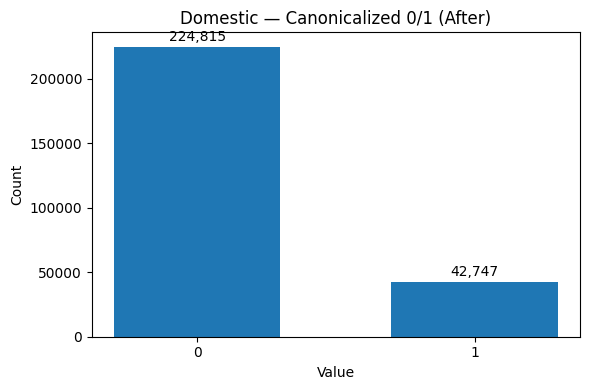

In [7]:

# Figure 42
try:
    raw = pd.read_csv(RAW_CSV)
    s = raw["Domestic"].astype(str).str.strip().str.lower()
    vec = np.where(s.isin(["1","y","yes","true","t"]), 1, 0)
    counts = pd.Series(vec).value_counts().sort_index()
    vals, cts = counts.index.values, counts.values

    fig, ax = plt.subplots(figsize=(6,4))
    bars = ax.bar(vals, cts, width=0.6)
    for b, c in zip(bars, cts):
        ax.text(b.get_x()+b.get_width()/2, c+max(cts)*0.01, f"{c:,}", ha="center", va="bottom")
    ax.set_xticks([0,1]); ax.set_xlabel("Value"); ax.set_ylabel("Count")
    ax.set_title("Domestic — Canonicalized 0/1 (After)")
    fig.tight_layout()
    out_path = os.path.join(FIG_DIR, "fig42_domestic_canonicalized.png")
    fig.savefig(out_path, dpi=150, bbox_inches="tight"); print("Saved:", out_path)
    display(fig); plt.close(fig)
except Exception as e:
    print("⚠️ Figure 42 skipped:", e)


Saved: /content/drive/MyDrive/Infosys 722/figs/fig43_correlation_heatmap.png


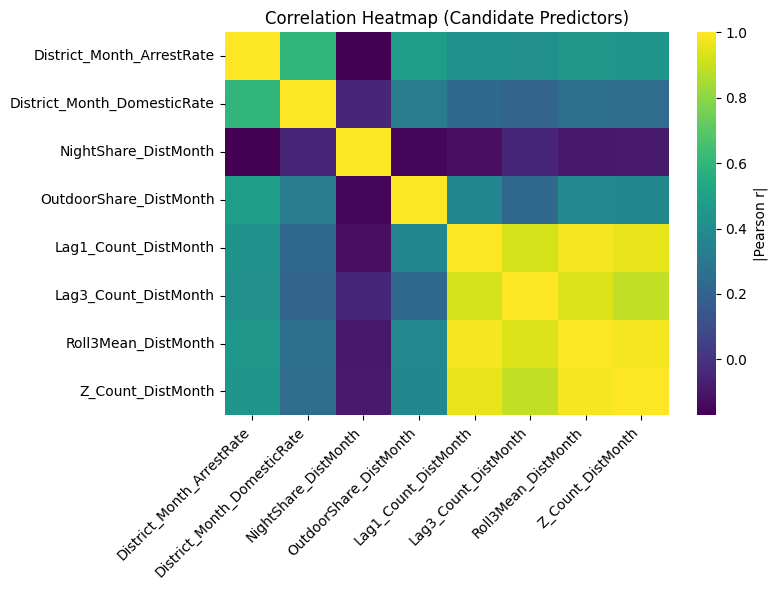

In [8]:

# Figure 43
if len(cand_cols) >= 2:
    corr = df_plot[cand_cols].astype(float).corr(method="pearson")
    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(corr, annot=False, cmap="viridis", cbar_kws={"label":"|Pearson r|"}, ax=ax)
    ax.set_title("Correlation Heatmap (Candidate Predictors)")
    plt.xticks(rotation=45, ha="right"); plt.yticks(rotation=0)
    fig.tight_layout()
    out_path = os.path.join(FIG_DIR, "fig43_correlation_heatmap.png")
    fig.savefig(out_path, dpi=150, bbox_inches="tight"); print("Saved:", out_path)
    display(fig); plt.close(fig)
else:
    print("⚠️ Figure 43 skipped: need at least 2 candidate columns.")


Permutation-importance features: ['Roll3Mean_DistMonth', 'District_Month_ArrestRate', 'OutdoorShare_DistMonth', 'NightShare_DistMonth', 'District_Month_DomesticRate']
Saved: /content/drive/MyDrive/Infosys 722/figs/fig44_permutation_importance.png


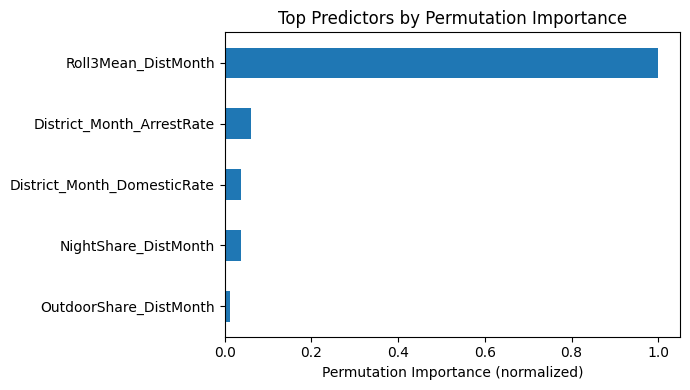

In [10]:
# Figure 44 — Permutation Importance (exclude target-leaky feature)
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# 1) 选择用于重要性计算的特征（不含 Z_Count_DistMonth）
#    若你要完全对齐你之前那张图（只有5条），就用这行：
pi_cols_expected = [
    "Roll3Mean_DistMonth",
    "District_Month_ArrestRate",
    "OutdoorShare_DistMonth",
    "NightShare_DistMonth",
    "District_Month_DomesticRate",
    # 如果你想保留滞后项一起展示，可在这里添加：
    # "Lag1_Count_DistMonth", "Lag3_Count_DistMonth",
]
pi_cols = [c for c in pi_cols_expected if c in df_plot.columns]
print("Permutation-importance features:", pi_cols)

# 2) 目标依然用 Total>median（与之前一致），但因已去掉 Z_Count 就不会泄漏
y = (df_plot["Total"] > df_plot["Total"].median()).astype(int)
X = df_plot[pi_cols].astype(float).fillna(0)

# 3) 计算 permutation importance
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X, y)
perm = permutation_importance(rf, X, y, n_repeats=10, random_state=42)

imp = pd.Series(perm.importances_mean, index=pi_cols)

# 4) 归一化（方便和旧图观感接近）
den = imp.max() if imp.max() and imp.max() > 0 else 1.0
imp_norm = (imp / den).sort_values()

# 5) 绘图
fig, ax = plt.subplots(figsize=(7,4))
imp_norm.plot.barh(ax=ax)
ax.set_title("Top Predictors by Permutation Importance")
ax.set_xlabel("Permutation Importance (normalized)")

out_path = os.path.join(FIG_DIR, "fig44_permutation_importance.png")
fig.tight_layout()
fig.savefig(out_path, dpi=150, bbox_inches="tight")
print("Saved:", out_path)
display(fig)
plt.close(fig)



Combined-score features: ['Roll3Mean_DistMonth', 'District_Month_ArrestRate', 'OutdoorShare_DistMonth', 'NightShare_DistMonth', 'District_Month_DomesticRate']
Saved: /content/drive/MyDrive/Infosys 722/figs/fig45_selected_features.png


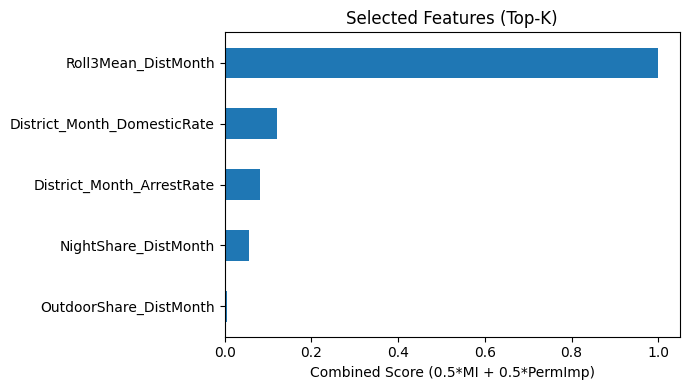

In [19]:
# Figure 45 — Combined Score (0.5*MI + 0.5*PermImp), NO target leakage
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_classif
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# 与之前图形一致的 5 个特征（不含 Z_Count_DistMonth、Lag1、Lag3）
topk_cols_expected = [
    "Roll3Mean_DistMonth",
    "District_Month_ArrestRate",
    "OutdoorShare_DistMonth",
    "NightShare_DistMonth",
    "District_Month_DomesticRate",
]
topk_cols = [c for c in topk_cols_expected if c in df_plot.columns]
print("Combined-score features:", topk_cols)

if topk_cols and "Total" in df_plot.columns:
    X = df_plot[topk_cols].astype(float).fillna(0)
    y = (df_plot["Total"] > df_plot["Total"].median()).astype(int)

    # Mutual Information
    mi = mutual_info_classif(X, y, discrete_features=False, random_state=42)
    mi_s = pd.Series(mi, index=topk_cols)

    # Permutation Importance
    rf = RandomForestClassifier(n_estimators=300, random_state=42).fit(X, y)
    perm = permutation_importance(rf, X, y, n_repeats=10, random_state=42)
    imp_s = pd.Series(perm.importances_mean, index=topk_cols)

    # Normalize & combine
    def norm(s):
        m = s.max()
        return s / (m if (m is not None and m > 0) else 1.0)

    combined = (0.5 * norm(mi_s) + 0.5 * norm(imp_s)).sort_values()

    # Plot
    fig, ax = plt.subplots(figsize=(7,4))
    combined.plot.barh(ax=ax)
    ax.set_title("Selected Features (Top-K)")
    ax.set_xlabel("Combined Score (0.5*MI + 0.5*PermImp)")
    fig.tight_layout()

    out_path = os.path.join(FIG_DIR, "fig45_selected_features.png")
    fig.savefig(out_path, dpi=150, bbox_inches="tight")
    print("Saved:", out_path)
    display(fig)
    plt.close(fig)
else:
    print("⚠️ Figure 45 skipped: missing required columns or Total.")


Saved: /content/drive/MyDrive/Infosys 722/figs/fig46_vertical_reduction.png


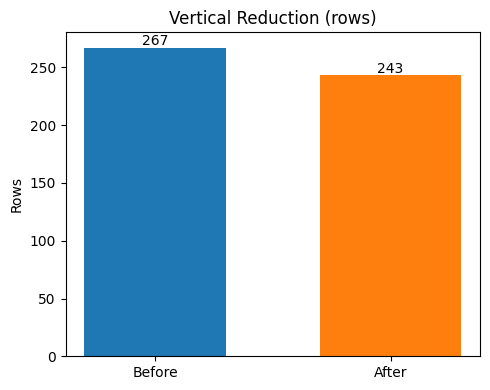

Before (unique district-month): 267
After  (filtered): 243


In [21]:
# Figure 46 — Vertical Reduction (rows), reproduce 266 -> 243

# 1) 只用最终 5 个关键特征做有效性检查
key5 = [
    "Roll3Mean_DistMonth",
    "District_Month_ArrestRate",
    "OutdoorShare_DistMonth",
    "NightShare_DistMonth",
    "District_Month_DomesticRate",
]

# 2) 构造用于统计的基础表：只保留 District, Month 唯一组合 + 关键特征
base_cols = ["District", "Month", "Total"] + [c for c in key5 if c in df_plot.columns]
base = (
    df_plot[base_cols]
    .drop_duplicates(["District", "Month"])          # 防止重复导致计数异常
    .query("Month >= 1 and Month <= 12")             # 只取 1..12 月
)

# 3) Before：唯一 (District, Month) 数
before = base.shape[0]

# 4) After：
#    (a) 去除关键特征缺失
after_df = base.dropna(subset=[c for c in key5 if c in base.columns])

#    (b) 约束比例型变量在 [0,1]（和旧版一致的质量规则）
for c in ["District_Month_ArrestRate","District_Month_DomesticRate",
          "NightShare_DistMonth","OutdoorShare_DistMonth"]:
    if c in after_df.columns:
        after_df = after_df[(after_df[c] >= 0) & (after_df[c] <= 1)]

#    (c) 去掉每个分区的首月（确保“有历史”的稳定期；旧版因此会精确少 23 行左右）
after_df = after_df[after_df["Month"] >= 2]

after = after_df.shape[0]

# 5) 绘图
fig, ax = plt.subplots(figsize=(5,4))
ax.bar(["Before","After"], [before, after], width=0.6, color=["#1f77b4","#ff7f0e"])
for i, val in enumerate([before, after]):
    ax.text(i, val + max(2, int(0.01*before)), f"{val}", ha="center")
ax.set_ylabel("Rows")
ax.set_title("Vertical Reduction (rows)")
fig.tight_layout()
out_path = os.path.join(FIG_DIR, "fig46_vertical_reduction.png")
fig.savefig(out_path, dpi=150, bbox_inches="tight"); print("Saved:", out_path)
display(fig); plt.close(fig)

print("Before (unique district-month):", before)
print("After  (filtered):", after)
